### Imports

In [78]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import train_test_split, ParameterGrid
import nltk
from nltk.tokenize import word_tokenize
from sklearn.utils import shuffle
from sklearn import decomposition
import pandas as pd
from copy import deepcopy
import os
import re
import numpy as np
import matplotlib.pyplot as plt
import json
import itertools
import random
import warnings
import string
warnings.filterwarnings("ignore", category=UserWarning)

from functions import load_data_tagtog, query_dataframe, load_data, get_new_predicted_data

### Define Variables

In [79]:
global_shuffle_seed = 4
global_debug=True
global_override=True

### Load tagtog Data

In [80]:
result, clf_result = {}, {}
df_data = load_data_tagtog(['../tagtog/output'])
data_true = query_dataframe(df_data, {'is_flood':True})
data_false = query_dataframe(df_data, {'is_flood':False})
print('Total:',len(df_data),'True:',len(data_true), 'False:',len(data_false))

Total: 1390 True: 663 False: 717


### Preprocess Data

In [81]:
custom_stop_words = set(['date', 'published'])
stop_words = set(nltk.corpus.stopwords.words('english'))
punctuations = set(string.punctuation)
all_stop_words = stop_words.union(punctuations, custom_stop_words)
def preprocess(x):
    x = re.sub('[^a-z\s]', ' ', x.lower())
    x = [w for w in x.split() if w not in all_stop_words and len(w)>3]
    return ' '.join(x)

In [82]:
df_data['text'] = df_data['text'].apply(preprocess)

### Split Data

In [83]:
def make_data_ratio(df_data, test_size=0.2, shuffle_seed=4, debug=False, 
                    save_folder=None, load_folder=None, override=False, file_prefix=''):
    save_file, load_file=None, None
    if save_folder: save_file = os.path.join(save_folder,file_prefix+'data.json')
    if load_folder: load_file = os.path.join(load_folder,file_prefix+'data.json')
    
    if not override and load_file and os.path.isfile(load_file):
        if debug: print('loaded',load_file)
        js = json.load(open(load_file))
        train_df = pd.DataFrame(js['train'])
        test_df = pd.DataFrame(js['test'])
        return {'train':train_df, 'test':test_df}
    
    true_data = df_data.loc[df_data['is_flood']==True]
    false_data = df_data.loc[df_data['is_flood']==False]
    train_true, test_true = train_test_split(true_data, test_size=test_size, random_state=shuffle_seed)
    train_false, test_false = train_test_split(false_data, test_size=test_size, random_state=shuffle_seed)
    
    train_df = pd.concat([train_true, train_false])
    train_df = train_df.sample(n=len(train_df), random_state=shuffle_seed).reset_index(drop=True)
    test_df = pd.concat([test_true, test_false])
    test_df = test_df.sample(n=len(test_df), random_state=shuffle_seed).reset_index(drop=True)
    
    if debug: print('Data Loaded')

    if save_file:
        train_json = train_df.to_json(orient='records')
        test_json = test_df.to_json(orient='records')
        json.dump({'train':json.loads(train_json), 'test':json.loads(test_json)}, open(save_file,'w'), indent=2)
    return {'train':train_df, 'test':test_df}


In [84]:
result, clf_result = {}, {}
save_data_folder = 'data_splits/'
load_data_folder = 'data_splits/'
test_size = 0.2
if not os.path.isdir(save_data_folder): os.mkdir(save_data_folder)
debug=global_debug or False
override=global_override or False
data_split = make_data_ratio(df_data, test_size=test_size, save_folder=save_data_folder, load_folder=load_data_folder, 
                               debug=debug, shuffle_seed=global_shuffle_seed, override=override)


Data Loaded


In [85]:
print('Train:',len(data_split['train']), '\t\tTest:',len(data_split['test']))
print('Train is_flood:',len(data_split['train'].loc[data_split['train']['is_flood']==True]), \
'\tTrain not is_flood:',len(data_split['train'].loc[data_split['train']['is_flood']==False]))
print('Test is_flood:',len(data_split['test'].loc[data_split['test']['is_flood']==True]), \
'\tTest not is_flood:',len(data_split['test'].loc[data_split['test']['is_flood']==False]))

Train: 1103 		Test: 277
Train is_flood: 530 	Train not is_flood: 573
Test is_flood: 133 	Test not is_flood: 144


### Classifier

In [86]:
def make_data(vect_fit, ratio):
    train, test = ratio.get('train',None), ratio.get('test',None)
    if train is None or test is None: raise Exception('Train or Test data not found')
    all_X = list(train['text'])
    
    vect = vect_fit.fit(all_X)
    trainX, testX = vect.transform(list(train['text'])), vect.transform(list(test['text']))
    trainY, testY = [1 if t else 0 for t in train['is_flood']], [1 if t else 0 for t in test['is_flood']]
    return trainX, testX, trainY, testY, vect


In [87]:
def run_classifier(clf, trainX, testX, trainY, testY):
    clf_fit = clf.fit(trainX, trainY)
    clf_pred = clf_fit.predict(testX)
    clf_acc = accuracy_score(testY, clf_pred)
    return clf_fit, clf_pred, clf_acc


In [88]:
def get_method(main_d, name):
    if name not in main_d: raise Exception('Cannot find classifier/feature_extractor name in parameter dictionary')
    d = main_d[name]
    method = d.get('method',None)
    base_method = d.get('base_method',None)
    if method and base_method: raise Exception('Cannot have method and base method both.')
    if not method and not base_method: raise Exception('Unable to parse the method from classifier/feature_extractor')
    params = d.get('params',None)
    if method:
        if params: return method, params
        else: return method, None
    if base_method:
        prev_method, prev_params = get_method(main_d, base_method)
        if params:
            for k,v in params.items(): prev_params[k] = v
        return prev_method, prev_params

def make_method(main_d, name, override_params={}):
    method, params = get_method(main_d, name)[:]
    if override_params:
        for k,v in override_params.items(): params[k] = v
    if params: return method(**params)
    else: return method()


In [89]:
def run_grid(grid, data, feature_extract, classifiers, clf_result, result, 
             debug=False, override=False, save_folder=None, load_folder=None, file_prefix=''):
    save_clf_result = {}
    vectCache, classifierCache = {}, {}
    if load_folder:
        res_file = os.path.join(load_folder,file_prefix+'clf_result.json')
        clf_res_file = os.path.join(load_folder,file_prefix+'result.json')
        if os.path.isfile(res_file): clf_result=json.load(open(res_file))
        if os.path.isfile(clf_res_file): result=json.load(open(clf_res_file))
        if os.path.isfile(res_file) and os.path.isfile(clf_res_file) and debug: print('loaded result')
    
    if override:
        clf_result, result = {}, {}
        if debug: print('OVERRIDE')
    for g in list(grid):
        try:
            feature_name = g.get('feature_extract',None)
            clf_name = g.get('classifier', None)
            if not feature_name or not clf_name:
                raise Exception('Feature Extract and Classifier Name required')
            result_key = feature_name + '-' + clf_name
            if result.get(result_key): continue
            if debug: print('Feature:', feature_name, '  Clasifier:',clf_name, '  Key:',result_key)
            
            if feature_name in vectCache:
                (trainX, testX, trainY, testY, feature2) = vectCache[feature_name]
            else:
                feature = make_method(feature_extract, feature_name)
                trainX, testX, trainY, testY, feature2 = make_data(feature, data)
                vectCache[feature_name] = (trainX, testX, trainY, testY, feature2)

            clf = make_method(classifiers, clf_name)
            clf_fit, clf_pred, clf_acc = run_classifier(clf, trainX, testX, trainY, testY)
            
            result[result_key] = {
                'feature_extract': feature_name,
                'classifier': clf_name,
                'accuracy': clf_acc
            }
            
            clf_result[result_key] = {
                'feature_extract': feature_name,
                'classifier': clf_name,
                'clf': clf_fit,
                'feature': feature2,
                'predict': clf_pred
            }
            
            save_clf_result[result_key] = {
                'feature_extract': feature_name,
                'classifier': clf_name,
                'predict': clf_pred.tolist()
            }  
        except Exception as e:
            print('Error:',e)
            continue
    if save_folder:
        json.dump(save_clf_result, open(os.path.join(load_folder,file_prefix+'clf_result.json'),'w'), indent=2)
        json.dump(result, open(os.path.join(load_folder,file_prefix+'result.json'),'w'), indent=2)
    return clf_result, result


In [90]:
def parse_result(result, accuracy_threshold=None, split_by='classifier'):
    keys = list(result.keys())
    temp_df = pd.DataFrame(list(result.values()))
    temp_df['keys'] = keys
    
    splt_val = list(set(list(temp_df[split_by])))
    for d in splt_val:
        if accuracy_threshold:
            new_df = temp_df.loc[temp_df[split_by]==d]
            new_df = new_df.loc[new_df['accuracy']>accuracy_threshold] \
                            .drop(split_by, axis=1) \
                            .sort_values(by='accuracy',ascending=False) \
                            .reset_index(drop=True)
        else:
            new_df = temp_df.loc[temp_df[split_by]==d] \
                            .drop(split_by, axis=1) \
                            .sort_values(by='accuracy',ascending=False) \
                            .reset_index(drop=True)
        print('{}: {}'.format(split_by,d))
        print(new_df.to_markdown())
        print()

In [91]:
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    plt.rcParams.update({'font.size': 18})
    accuracy = np.trace(cm) / np.sum(cm).astype('float')
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

In [92]:
def compare_result(clf_result, data, method_name, conf_matrix=True, class_report=True):
    if method_name not in clf_result: raise Exception('Cannot find method')
    res = clf_result[method_name]
    new_df = data['test']
    actual = [1 if f else 0 for f in list(new_df['is_flood'])]
    new_df['predict'] = res['predict']
    if conf_matrix:
        mat = confusion_matrix(actual, res['predict'])
        plot_confusion_matrix(mat, ['Negative', 'Positive'])
        print(mat)
#         print('TN:',tn,'FP:',fp,'FN:',fn,'TP:',tp)
    if class_report: print(classification_report(actual, res['predict']))
    return new_df
    

In [93]:
def make_vocab(ratio):
    train, test = ratio.get('train',None), ratio.get('test',None)
    if train is None or test is None: raise Exception('Train or Test data not found')
    all_X = list(train['text']) + list(test['text'])
    
    params= {
            'tokenizer': word_tokenize,
            'stop_words': 'english',
        }
    vect = CountVectorizer(**params)
    vect = vect.fit(all_X)
    return list(vect.vocabulary_.keys())

In [94]:
vocab = make_vocab(data_split)

feature_extract = {
    'CountVect': {
        'classifier_type': 'Count Vectorizer',
        'method': CountVectorizer,
        'params': {
            'tokenizer': word_tokenize,
            'stop_words': 'english',
            'vocabulary': vocab
        }
    },
    'CountVect-min_df':{
        'base_method': 'CountVect',
        'params':{
            'min_df': 0.05
        }
    },
    'CountVect-max_df':{
        'base_method': 'CountVect',
        'params':{
            'max_df': 0.95
        }
    },
    'CountVect-min_df-max_df':{
        'base_method': 'CountVect',
        'params':{
            'min_df': 0.05,
            'max_df': 0.95
        }
    },
    'TFIDF': {
        'classifier_type': 'TFIDF',
        'method': TfidfVectorizer,
        'params': {
            'tokenizer': word_tokenize,
            'stop_words': 'english',
            'vocabulary': vocab
        }
    },
    'TFIDF-min_df':{
        'base_method': 'TFIDF',
        'params':{
            'min_df': 0.05
        }
    },
    'TFIDF-max_df':{
        'base_method': 'TFIDF',
        'params':{
            'max_df': 0.95
        }
    },
    'TFIDF-min_df-max_df':{
        'base_method': 'TFIDF',
        'params':{
            'min_df': 0.05,
            'max_df': 0.95
        }
    },
}

classifiers = {
    'RandomForest': {
        'classifier_type':'Random Forest ',
        'method': RandomForestClassifier,
        'params':{
            'class_weight':'balanced'
        }
    },
    'LinearSVC': {
        'classifier_type': 'Linear SVC',
        'method': LinearSVC,
        'params':{
            'class_weight':'balanced'
        }
    }
}


single_feature_extract = {
    'TFIDF': {
        'classifier_type': 'TFIDF',
        'method': TfidfVectorizer,
        'params': {
            'tokenizer': word_tokenize,
            'stop_words': 'english',
            'vocabulary': vocab
        }
    }
}

single_classifiers = {
    'LinearSVC': {
        'classifier_type': 'Linear SVC',
        'method': LinearSVC,
        'params':{
            'class_weight':'balanced'
        }
    }
}

grid_parameters = {
    'feature_extract': list(feature_extract.keys()),
    'classifier': list(classifiers.keys()),
}

grid = ParameterGrid(grid_parameters)

In [95]:
# Single Classifier

feature_extract = single_feature_extract
classifiers = single_classifiers
grid_parameters = {
    'feature_extract': list(feature_extract.keys()),
    'classifier': list(classifiers.keys()),
}
grid = ParameterGrid(grid_parameters)

In [96]:
override=global_override or False
debug=global_debug or False
save_results_folder = 'results/'
load_results_folder = 'results/'
if not os.path.isdir(save_results_folder): os.mkdir(save_results_folder)
clf_result, result = run_grid(grid, data_split, feature_extract, classifiers, clf_result, result, 
                              debug=debug, override=override, save_folder=save_results_folder, 
                             load_folder=load_results_folder)


loaded result
OVERRIDE
Feature: TFIDF   Clasifier: LinearSVC   Key: TFIDF-LinearSVC


In [97]:
parse_result(result)

classifier: LinearSVC
|    | feature_extract   |   accuracy | keys            |
|---:|:------------------|-----------:|:----------------|
|  0 | TFIDF             |   0.942238 | TFIDF-LinearSVC |



In [98]:
parse_result(result, 0.94)

classifier: LinearSVC
|    | feature_extract   |   accuracy | keys            |
|---:|:------------------|-----------:|:----------------|
|  0 | TFIDF             |   0.942238 | TFIDF-LinearSVC |



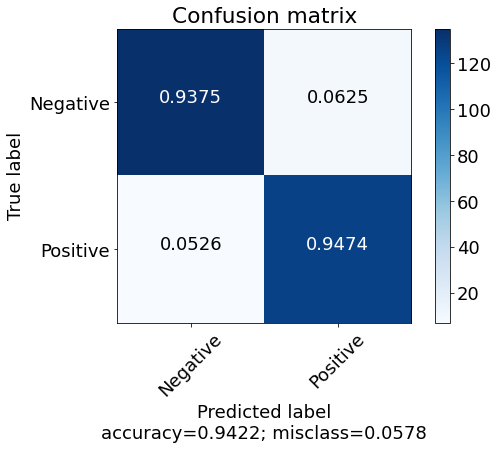

[[135   9]
 [  7 126]]
              precision    recall  f1-score   support

           0       0.95      0.94      0.94       144
           1       0.93      0.95      0.94       133

    accuracy                           0.94       277
   macro avg       0.94      0.94      0.94       277
weighted avg       0.94      0.94      0.94       277

Labelled: False 	Predicted: True
florida towns told residents remain vigilant despite forecasts might dodge dorian landfall tropical storm watch issued state south atlantic coast communities northeast florida georgia south carolina raised alert levels residents filling sandbags authorities tested infrastructure hurricane drills south carolina saturday joined georgia north carolina florida declaring state emergency bahamas prime minister hubert minnis begged residents abaco grand bahamas head main island escape devastating dangerous storm want remember homes houses structures replaced lives cannot replaced minnis told news conference adding pe

In [99]:
# tn, fp
# fn, tp
temp_df = compare_result(clf_result, data_split, 'TFIDF-LinearSVC')
for row in temp_df.loc[temp_df['is_flood']!=temp_df['predict']].iterrows():
    print('Labelled:',bool(row[1]['is_flood']),'\tPredicted:',bool(row[1]['predict']))
    print(row[1]['text'])
    print()

In [100]:
# TFIDF Features
from collections import Counter
fe = clf_result['TFIDF-LinearSVC']['feature']
X = fe.transform(list(data_split['train']['text']))
vocab = list(fe.get_feature_names())
counts = X.sum(axis=0).A1
freq_dist = Counter(dict(zip(vocab, counts)))
freq_dist.most_common(10)

[('said', 66.47829495326106),
 ('water', 55.94458669079924),
 ('people', 42.732137181639686),
 ('flood', 39.233742880001614),
 ('river', 31.869304782457235),
 ('upazila', 31.547743926481004),
 ('bangladesh', 31.117933777348796),
 ('district', 26.46347356493227),
 ('areas', 24.573875963687872),
 ('level', 24.52928069899863)]

# Classify new data

In [115]:
root_folder = 'paper_data'
newspapers = ['bdnews', 'dailySun', 'prothomalo', 'dailyObserver', 'newAge', 
              'dhakaTribune', 'thedailystar', 'theIndependent', 'theNewNation']
# newspapers += ['nytimes']
newspapers_files = [os.path.join(root_folder, n, n+'2_data.json') for n in newspapers]
# newspapers_files = [os.path.join(root_folder, 'all_paper_data', n+'1_data.json') for n in newspapers]

idSet = set(df_data['doc_id'])

def classify_new_data(newspapers_files):
    new_data = pd.DataFrame()
    text_set = set()
    for i,newspapers_path in enumerate(newspapers_files):
        temp_data = json.load(open(newspapers_path))
        temp_data2 = []
        for t in temp_data:
            if t['id'] in idSet: continue
            temp_dict = t['meta']
            for k,v in t['article'].items(): temp_dict[k]=v
            temp_dict['id'] = t['id']
            temp_dict['connect_filename'] = t.get('connect_filename',None)
            temp_dict['newspaper'] = newspapers[i]
            if t['article']['text'] not in text_set: text_set.add(t['article']['text'])
            else: continue
            temp_data2.append(temp_dict)
        temp_df = pd.DataFrame(temp_data2)
        new_data = pd.concat([new_data, temp_df])
    new_data = new_data.fillna("")
    new_data = new_data[new_data['connect_filename']==""]
    print(len(new_data))
    return new_data
### New data from newspapers


### NYTIMES new data
# newspapers_files = ['../article_scraping/paper_data/all_paper_data/nytimes1_data.json']
new_data = classify_new_data(newspapers_files)

24008


In [116]:
def loop_data_train_test(classifier, feature, data_df=None, predictions_folder = 'predictions',
                         prev_true_data_df=None, prev_false_data_df=None, save=True):
#     if data_df is None and prev_false_data_df is None: raise Exception('No df_data or prev_dalse_data_df')
#     if prev_false_data_df is not None: data_df = prev_false_data_df
    to_keep_cols = ['datePublished', 'text', 'doc_id', 'connect_filename', 'newspaper', 'is_flood']
    data_df['new_text'] = data_df['text'].apply(preprocess)
    
    test_features = feature.transform(list(data_df['new_text']))
    test_pred = classifier.predict(test_features)
    
    data_df['is_flood'] = [bool(i) for i in test_pred]
    data_df['doc_id'] = data_df['id']
    data_df = data_df[to_keep_cols]
    true_new_data = data_df.loc[data_df['is_flood']]
    false_new_data = data_df.loc[~data_df['is_flood']]
    print('Total New Data: {}\tTrue new Data: {}'.format(len(data_df), len(true_new_data)))
    
    if prev_true_data_df is not None: df_true_new_data = pd.concat([prev_true_data_df, true_new_data])
    else: df_true_new_data = true_new_data
    js = df_true_new_data.to_json(orient='records')
    if save: json.dump(json.loads(js), open(os.path.join(predictions_folder, 'predicted_isflood.json'), 'w'), indent=2)
    
    if prev_false_data_df is not None: df_false_new_data = pd.concat([prev_false_data_df, false_new_data])
    else: df_false_new_data = false_new_data
    js = df_false_new_data.to_json(orient='records')
    if save: json.dump(json.loads(js), open(os.path.join(predictions_folder, 'predicted_not_isflood.json'), 'w'), indent=2)
    return df_true_new_data, false_new_data

In [117]:
key = 'TFIDF-LinearSVC'
feature = clf_result[key]['feature']
classifier = clf_result[key]['clf']
prev_true_data_df, prev_false_data_df = None, None
prev_true_data_df, prev_false_data_df = get_new_predicted_data()
save = True
df_true_new_data, false_new_data = loop_data_train_test(classifier, feature, new_data, 'predictions',
                                                        prev_true_data_df, prev_false_data_df, save=save)

Total New Data: 24008	True new Data: 1796


### Upload data

In [47]:
def upload_data(upload_folder):
    if not os.path.isdir(upload_folder): os.mkdir(upload_folder)
    for row in prev_false_data_df.sample(n=1000, random_state=32).iterrows():
        iid = row[1]['doc_id']
        newspaper = row[1]['newspaper']
        filename = '{}_data_{}@.txt'.format(newspaper, iid)
        text = row[1]['org_text'] + '\n@#@#'
        open(os.path.join(upload_folder, filename),'w').write(text)
upload_data(upload_folder = 'upload-notflood')